In [80]:
using QuantumToolbox
using Plots

In [10]:
# Define lattice 
Nx, Ny = 3, 2
latt = Lattice(Nx=Nx, Ny=Ny)

N_cut = 2         # Number of states of each mode
N_modes = latt.N  # Number of modes
N = N_cut^N_modes # Total number of states
M = Nx*Ny+1;      # Number of states in the LR basis

In [11]:
ϕ = Vector{QuantumObject{Vector{ComplexF64}, KetQuantumObject}}(undef, M)
ϕ[1] = kron(repeat([basis(2,0)],N_modes)...)

global i=1
for j in 1:N_modes
    global i+=1
    i<=M && (ϕ[i] = mb(sp, j, latt) * ϕ[1])
end
for k in 1:N_modes-1
    for l=k+1:N_modes
        global i+=1
        i<=M && (ϕ[i] = mb(sp, k, latt) * mb(sp, l, latt) * ϕ[1])
    end
end
for i in i+1:M
    ϕ[i] = QuantumObject(rand(ComplexF64,size(ϕ[1])[1]), dims=ϕ[1].dims)
    normalize!(ϕ[i])
end

In [12]:
# Define initial state
z  = hcat(broadcast(x->x.data, ϕ)...)
p0 = 0. # Population of the lr states other than the initial state
B  = Matrix(Diagonal([1+0im; p0 * ones(M-1)]))
S  = z'*z # Overlap matrix
B = B / tr(S*B) # Normalize B

ρ = QuantumObject(z*B*z', dims=ones(Int,N_modes)*N_cut); # Full density matrix

In [19]:
# Define Hamiltonian and collapse operators
Jx = 0.9 
Jy = 1.0
Jz = 1. 
hx = 0.
γ  = 1

Sx = sum([mb(sx, i, latt) for i in 1:latt.N])
Sy = sum([mb(sy, i, latt) for i in 1:latt.N])
Sz = sum([mb(sz, i, latt) for i in 1:latt.N])
SFxx = sum([mb(sx, i, latt) * mb(sx, j, latt) for i in 1:latt.N for j in 1:latt.N])

H, c_ops = TFIM(Jx, Jy, Jz, hx, γ, latt; bc=pbc, order=1)
e_ops = (Sx,Sy,Sz,SFxx)

tl = LinRange(0,10,100);

In [20]:
# Full evolution
@time mesol = mesolve(H, ρ, tl, c_ops; e_ops=[e_ops...]);
A = Matrix(mesol.states[end].data)
λ = eigvals(Hermitian(A))
Strue  = -sum(λ.*log2.(λ))/latt.N;

  0.087596 seconds (834 allocations: 22.407 MiB)


In [87]:
function f_purity(p,z,B)
    N  = p.N
    M  = p.M
    S  = p.S
    T  = p.temp_MM

    mul!(T, S, B)
    tr(T^2)
end

function f_trace(p,z,B)
    N  = p.N
    M  = p.M
    S  = p.S
    T  = p.temp_MM

    mul!(T,S,B)
    tr(T)
end

function f_entropy(p,z,B)
    C = p.A0
    σ = p.Bi

    mul!(C, z, sqrt(B))
    mul!(σ, C', C)
    λ = eigvals(Hermitian(σ))
    λ = λ[λ.>1e-10]
    return -sum(λ .* log2.(λ))
end

function f_error(p,z,B)
    if p.opt.adj_condition=="variational" 
        return abs(p.scalars[1]*sqrt(p.M))
        
    elseif p.opt.adj_condition=="ratio"
        C   = p.temp_NM
        σ   = p.temp_MM
        
        mul!(C, z, sqrt(B))
        mul!(σ, C', C)
        λ = abs.(eigvals(σ))
        return λ[1]/λ[end]
    end
end;

In [88]:
opt = LRMesolveOptions( 
    alg        = Tsit5(),
    err_max    = 1e-4,
    p0         = 0.,
    atol_inv   = 1e-6,
    compute_Si = true, 
    adj_condition="variational",
    Δt = 0.
);

@time lrsol = lr_mesolve(H, z, B, tl, c_ops; e_ops=e_ops, f_ops=(f_purity, f_entropy, f_trace, f_error), opt=opt);

Progress: 100%
  3.934191 seconds (3.89 M allocations: 951.706 MiB, 1.23% gc time, 34.53% compilation time)


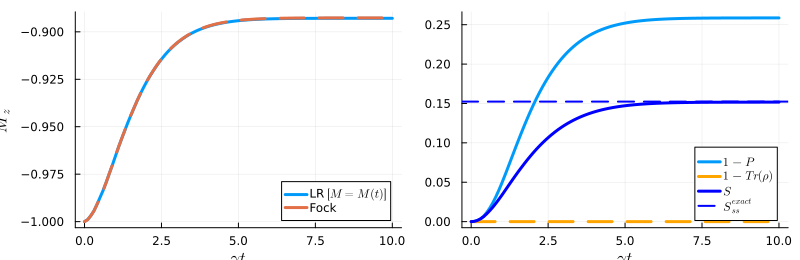

In [117]:
fig = plot(layout=(1,2), size=(800,260), legend=:bottomright, xlabel=raw"$\gamma t$")

m_me = real(mesol.expect[3,:])/Nx/Ny
m_lr = real(lrsol.expvals[3,:])/Nx/Ny

plot!(fig[1], tl, m_lr, label=raw"LR $[M=M(t)]$", lw=3)
plot!(fig[1], tl, m_me, ls=:dash, label="Fock", lw=3)
ylabel!(fig[1], raw"$M_{z}$")

plot!(fig[2], tl, 1 .-real(lrsol.funvals[1,:]), label=raw"$1-P$", lw=3)
plot!(fig[2], tl, 1 .-real(lrsol.funvals[3,:]), c=:orange, label=raw"$1-\rm{Tr}(\rho)$", lw=3, ls=:dash)
plot!(fig[2], tl, real(lrsol.funvals[2,:])/Nx/Ny, c=:blue, label=raw"$S$", lw=3)
hline!(fig[2], [Strue], c=:blue, ls=:dash, lw=2, label=raw"$S^{\rm exact}_{\rm ss}$")

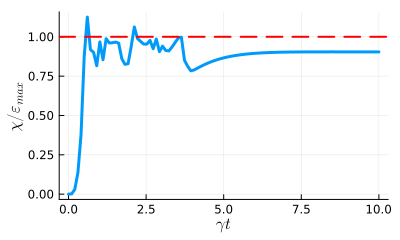

In [119]:
fig = plot(layout=(1,1), size=(400,240), xlabel=raw"$\gamma t$", ylabel=raw"$\chi/\epsilon_{\rm max}$", )
chi = real(lrsol.funvals[end,:])
plot!(fig[1], tl, chi./opt.err_max, lw=3, label="")

hline!(fig[1], [1], c=:red, ls=:dash, lw=2., label="")

# # yscale("log")
# ax.set_xscale("log")
# ax.set_xlabel(L"\gamma t")
# ax.set_ylabel(L"\chi");